In [1]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm.notebook import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
training = False
#check if cuda is available
torch.cuda.is_available()

True

In [3]:
# Data
n_tracks = 5  # number of tracks
n_pitches = 72  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 4  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48]  # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # name of each track
tempo = 100

# Training
batch_size = 16
latent_dim = 128
n_steps = 8000

# Sampling
sample_interval = 100  # interval to run the sampler (in step)
n_samples = 4

In [4]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)

## Data Preparation

In [5]:
if training==False:
    dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
    id_list = []
    for path in os.listdir("data/lpd_5/amg"):
        filepath = os.path.join("data/lpd_5/amg", path)
        if os.path.isfile(filepath):
            with open(filepath) as f:
                id_list.extend([line.rstrip() for line in f])
    id_list = list(set(id_list))
    
    # print(id_list)

In [6]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

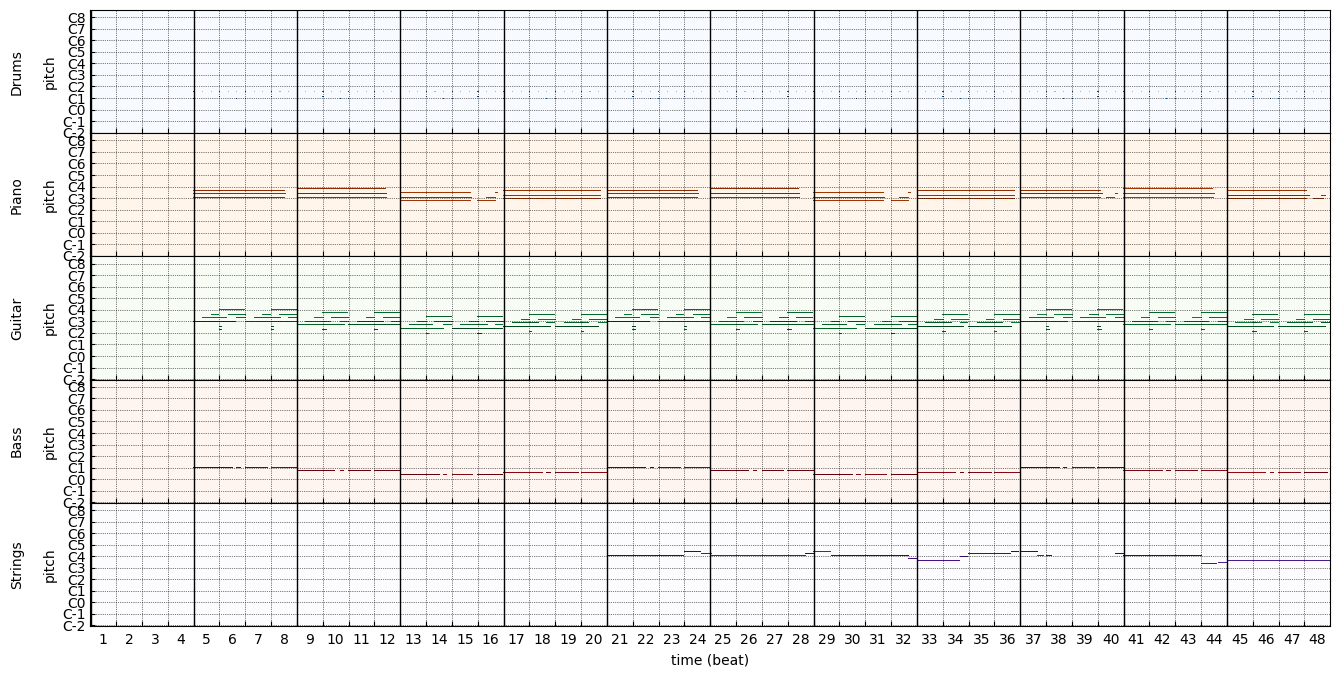

In [7]:
if training==False:
    song_dir = dataset_root / msd_id_to_dirs('TREVDFX128E07859E0') # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    multitrack.trim(end=12 * 96)
    axs = multitrack.plot()
    plt.gcf().set_size_inches((16, 8))
    for ax in axs:
        for x in range(96, 12 * 96, 96):     
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.show()

In [8]:
data = []
# Iterate over all the songs in the ID list
for msd_id in tqdm(id_list, dynamic_ncols=True):
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root / msd_id_to_dirs(msd_id)
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}")

  0%|          | 0/7323 [00:00<?, ?it/s]

Successfully collect 13174 samples from 7323 songs
Data shape : (13174, 5, 64, 72)


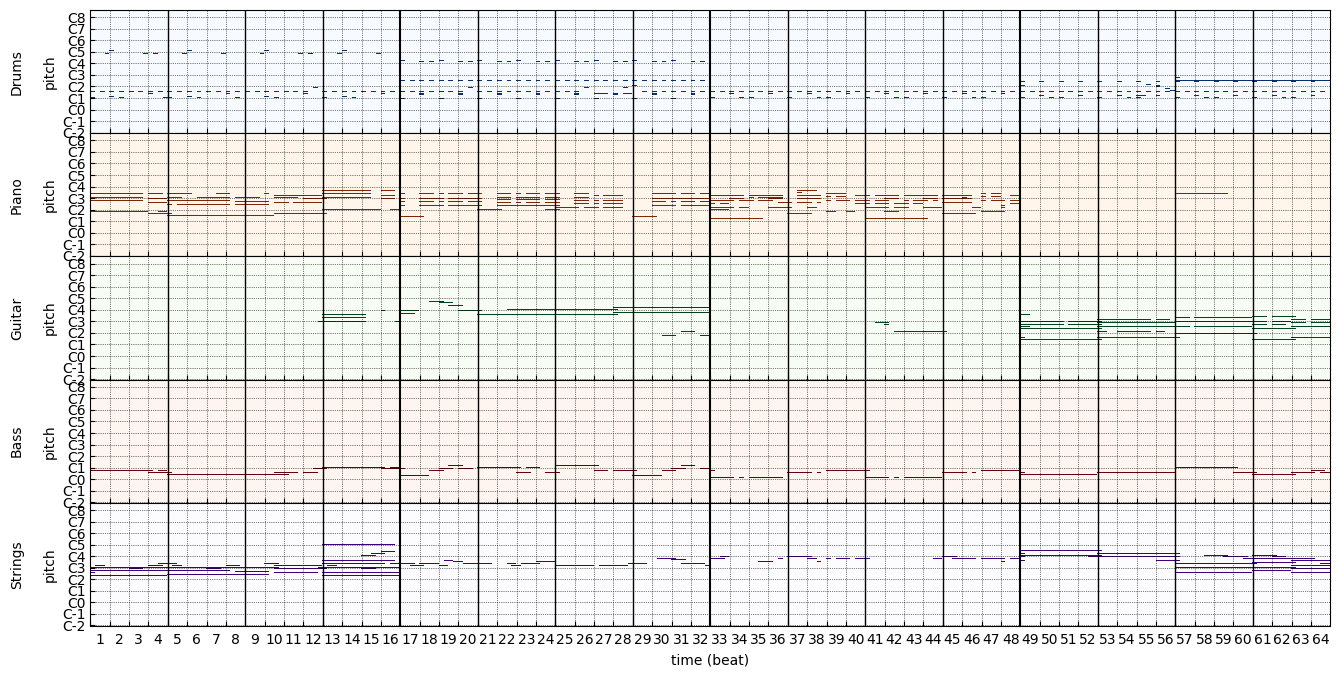

In [9]:
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset


# 合并前四个音轨 (示例)
data = data.reshape(-1, 5 * 64, 72)  # 新的形状将是 (13174, 320, 72)
print(f"Data shape : {data.shape}")

sequence_length = 100  # 序列长度
X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data[i:i + sequence_length])
    y.append(data[i + sequence_length])

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

batch_size = 64
data_loader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)


In [ ]:
class MusicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(MusicRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# 模型参数
input_size = 72  # 音高数
hidden_size = 256  # 隐藏层大小
output_size = 72  # 输出大小（音高数，与输入相同）
num_layers = 2  # LSTM层的数量

# 初始化模型
model = MusicRNN(input_size, hidden_size, output_size, num_layers)

# 模型到设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)




In [ ]:
# 损失函数和优化器
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 训练循环
num_epochs = 50
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')

In [ ]:
def generate_music(model, start_sequence, num_generate):
    model.eval()
    sequence = start_sequence
    generated_sequence = []

    for _ in range(num_generate):
        with torch.no_grad():
            prediction = model(sequence)
            next_note = prediction[-1]
            generated_sequence.append(next_note)

            # 更新序列
            sequence = torch.cat((sequence[1:], next_note.unsqueeze(0)))

    return generated_sequence

start_sequence = torch.randn(1, sequence_length, 72)
generated_music = generate_music(model, start_sequence, 500)


# generated_music = generated_music.cpu().detach().numpy()

# 将生成的音乐数据转换为二值格式（0和1），这里假设它已经是二值的
binary_music = np.where(generated_music > 0.5, 1, 0)

# 创建一个轨道
track = Track(pianoroll=binary_music, program=0, is_drum=False, name='Piano')

# 创建一个多轨音乐
multitrack = Multitrack(tracks=[track], tempo=120.0, beat_resolution=24)

# 保存为MIDI文件
pypianoroll.write(multitrack, 'RNN_Single_node_music.mid')
